In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import requests
import zipfile
import geopandas as gpd
import urllib3

# Extracting data from [US Environmental Protection Agency](https://aqs.epa.gov/aqsweb/airdata/download_files.html)

The following code downloads every single `.zip` file from the Annual Summary Data table, specifically the AQI by County column. Then the `.csv` files are extracted and concatenated into a single pandas dataframe. The resulting dataframe, `final_df` is converted into `combined_aqi_by_county.csv` and saved to drive.

Getting the file from Drive is faster than doing this entire process everytime a new runtime connection has to be made.

(Last run: May 7th, 2025)

```
import os
import zipfile
import shutil

# Create directories for zipped and extracted data if they don't exist
os.makedirs('/content/zipped', exist_ok=True)
os.makedirs('/content/extracted_data', exist_ok=True)

# Download all ZIP files for 2024 to 1980 into the 'zipped' folder
base_url = 'https://aqs.epa.gov/aqsweb/airdata/annual_aqi_by_county_{}.zip'

for year in range(2024, 1979, -1):  # Download files from 2024 to 1980
    zip_file_name = os.path.join('/content/zipped', f'annual_aqi_by_county_{year}.zip')  # Save as annual_aqi_by_county_YEAR.zip
    download_url = base_url.format(year)
    print(f"Downloading {download_url}...")
    !wget -O {zip_file_name} {download_url}

# Unzip each downloaded file into 'extracted_data'
for zip_file in os.listdir('/content/zipped'):
    zip_file_path = os.path.join('/content/zipped', zip_file)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/extracted_data')

# Delete the 'zipped' folder and its contents after extraction
shutil.rmtree('/content/zipped')
shutil.rmtree('/content/sample_data')

# Verify extraction
!ls /content/extracted_data

# Initialize an empty list to hold individual DataFrames
df_list = []

# Read all CSV files from the extracted data and combine them into a single DataFrame
for file in os.listdir('/content/extracted_data'):
    if file.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join('/content/extracted_data', file)
        print(f"Reading {file_path}...")
        df = pd.read_csv(file_path)  # Read each CSV file into a DataFrame
        df_list.append(df)  # Add the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
final_df.head()

# Save the DataFrame to a CSV file
final_df.to_csv('/content/combined_aqi_by_county.csv', index=False)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path inside your Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Datasets, spreadsheets, etc.'

# Create the folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Save the DataFrame to that path
final_df.to_csv(f'{output_path}/combined_aqi_by_county.csv', index=False)

## (Optional) Download the CSV file
# from google.colab import files
# files.download('/content/combined_aqi_by_county.csv')
```

# Getting the data

In [2]:
# Easy simple way of accessing my datasets
aqi_df_sharelink = 'https://drive.google.com/file/d/130DVMpCfi1dujuygMyI8bzoP1fvSONvO/view?usp=drive_link' # this is the link received when clicked the Share button in Google Drive
aqi_df = pd.read_csv('https://drive.google.com/uc?export=download&id='+aqi_df_sharelink.split('/d/')[1].split('/')[0]) # this parses the string from the line above to make a download link

aqi_df = aqi_df[aqi_df['State'] != 'Country Of Mexico'].copy() # dropping Mexico from the analysis

In [3]:
## - getting a row with hazardous days and a smaller value of days with AQI to serve as example in the README.md
# aqi_df[((aqi_df['Hazardous Days'] + 100) >= aqi_df['Days with AQI']) & (aqi_df['Hazardous Days'] >= 1)]

| **Column**                              | **Description**                                                                                                                                                                                    |
| --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Days with AQI**                       | Total number of days in the year for which the Air Quality Index (AQI) was calculated.                                                                                                             |
| **Good Days**                           | Number of days the AQI was in the "Good" range (0–50), meaning air quality was satisfactory with little or no risk.                                                                                |
| **Moderate Days**                       | Number of days the AQI was in the "Moderate" range (51–100), which may pose a minor risk to a very small number of sensitive individuals.                                                          |
| **Unhealthy for Sensitive Groups Days** | Days when AQI was in the 101–150 range, where sensitive individuals (e.g., elderly, children, those with asthma) may experience health effects, but the general public is unlikely to be affected. |
| **Unhealthy Days**                      | Days with AQI in the 151–200 range. Everyone may begin to experience health effects, and members of sensitive groups may experience more serious effects.                                          |
| **Very Unhealthy Days**                 | Days with AQI between 201–300. Health alert: everyone may experience more serious health effects.                                                                                                  |
| **Hazardous Days**                      | Days with AQI above 300. Health warnings of emergency conditions: the entire population is more likely to be affected.                                                                             |
| **Max AQI**                             | The highest (worst) AQI value recorded for the county during the year.                                                                                                                             |
| **90th Percentile AQI**                 | The AQI value below which 90% of the daily AQI values fall. This gives an idea of how bad AQI gets on the worse days, without considering extremes.                                                |
| **Median AQI**                          | The middle AQI value for the year—half of the AQI values were above this, and half were below.                                                                                                     |
| **Days CO**                             | Number of days where carbon monoxide (CO) was the primary pollutant determining the AQI.                                                                                                           |
| **Days NO2**                            | Number of days where nitrogen dioxide (NO₂) was the primary pollutant determining the AQI.                                                                                                         |
| **Days Ozone**                          | Number of days where ground-level ozone was the dominant pollutant affecting the AQI.                                                                                                              |
| **Days PM2.5**                          | Number of days where fine particulate matter (PM2.5) was the primary pollutant.                                                                                                                    |
| **Days PM10**                           | Number of days where coarse particulate matter (PM10) was the primary pollutant.                                                                                                                   |


# Analyzing the data

In [4]:
# Define URLs and paths
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
zip_path = '/content/USshape_zipped/cb_2021_us_state_20m.zip'
extract_path = '/content/USshape_extracted/'
shapefile_path = os.path.join(extract_path, 'cb_2021_us_state_20m.shp')

# Check if shapefile already exists
if not os.path.exists(shapefile_path):
    print("Shapefile not found — downloading and extracting...")

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(zip_path), exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)

    # Disable SSL warnings and download ZIP file
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    response = requests.get(url, verify=False)
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    # Extract contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Download and extraction complete.")
else:
    print("Shapefile already exists — skipping download.")

# Load shapefile
states = gpd.read_file(shapefile_path)

Shapefile not found — downloading and extracting...
Download and extraction complete.


In [ ]:
# Data prep
year2024 = aqi_df[aqi_df['Year'] == 2024]
year2024_avg_state = year2024.groupby('State')['Median AQI'].mean().reset_index()

# Drop unwanted regions (e.g., Puerto Rico, DC)
states = states[~states['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico', 'District of Columbia'])]

# Map full state names to abbreviations
state_to_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

year2024_avg_state['State Abbrev'] = year2024_avg_state['State'].map(state_to_abbrev)

states['State Abbrev'] = states['NAME'].map(state_to_abbrev)

# Merge the GeoDataFrame with AQI data
aqi_map = states.merge(year2024_avg_state, on='State Abbrev')

# Optional: project to a projected CRS for better centroid placement
aqi_map = aqi_map.to_crs(epsg=2163)

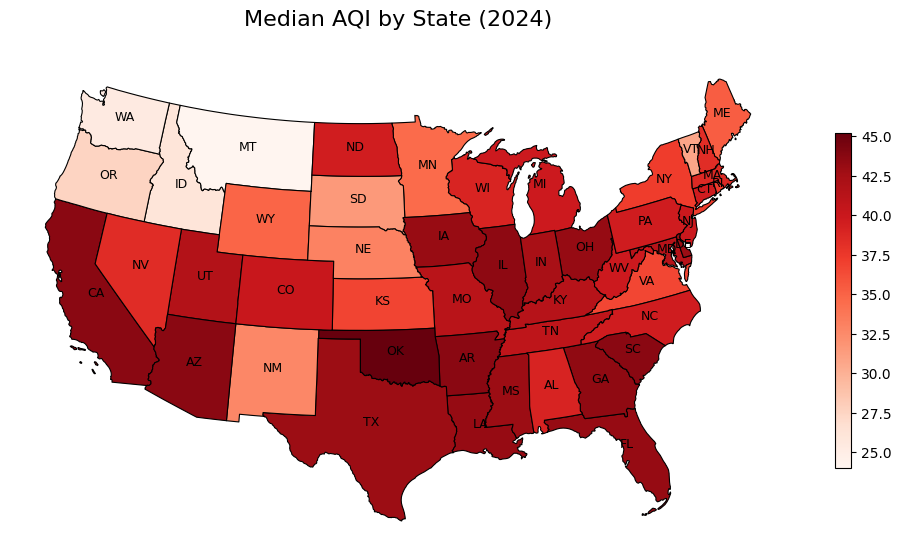

In [23]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Choropleth colored by Median AQI
aqi_map.plot(
    column='Median AQI',
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='0',
    legend=True,
    legend_kwds={'label': "", 'shrink': 0.5}
)

# Add state abbreviation labels on centroids
for idx, row in aqi_map.iterrows():
    plt.annotate(
        text=row['State Abbrev'],
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        ha='center',
        fontsize=9,
        color='black'
    )

ax.set_title("Median AQI by State (2024)\n", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

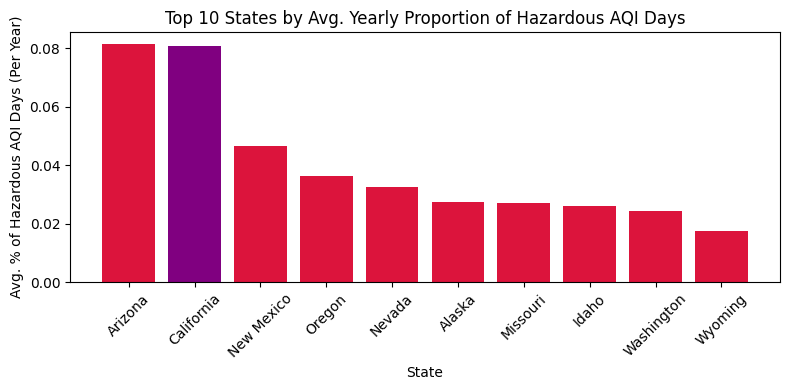

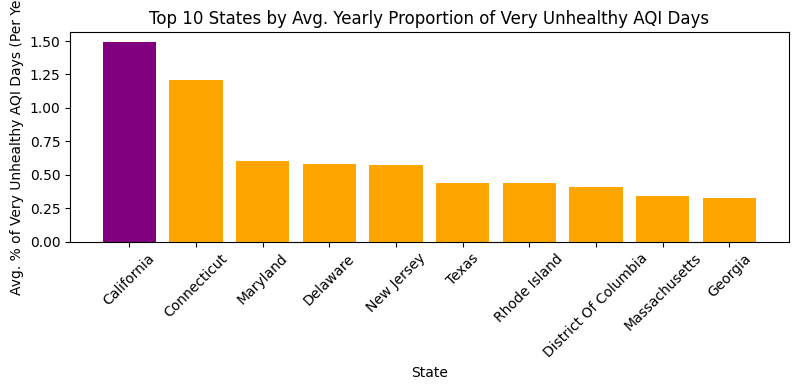

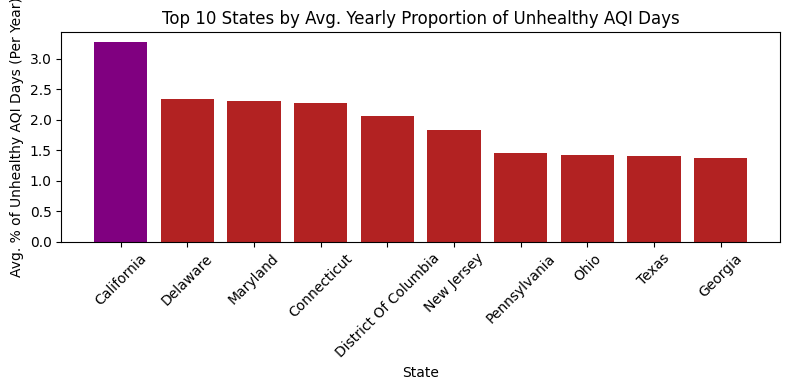

In [6]:
# Group by State and Year, calculate per-year proportions
yearly = aqi_df.groupby(['State', 'Year']).apply(
    lambda x: pd.Series({
        'Yearly Good Proportion': x['Good Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Moderate Proportion': x['Moderate Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Unhealthy for Sensitive Groups Proportion': x['Unhealthy for Sensitive Groups Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Unhealthy Proportion': x['Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Very Unhealthy Proportion': x['Very Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Hazardous Proportion': x['Hazardous Days'].sum() / x['Days with AQI'].sum(),
        'Total Days with AQI': x['Days with AQI'].sum()  # Optional, useful for reference
    }),
    include_groups=False
).reset_index()

# Average across years per state
state_avg = yearly.groupby('State').mean().reset_index()

# Plot top 10 states by average yearly hazardous proportion
top10_hazardous = state_avg.sort_values(by='Yearly Hazardous Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'crimson' for state in top10_hazardous['State']]
plt.bar(top10_hazardous['State'], top10_hazardous['Yearly Hazardous Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Hazardous AQI Days (Per Year)')
plt.title('Top 10 States by Avg. Yearly Proportion of Hazardous AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 10 states by average yearly Very Unhealthy proportion
top10_unhealthy = state_avg.sort_values(by='Yearly Very Unhealthy Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'orange' for state in top10_unhealthy['State']]
plt.bar(top10_unhealthy['State'], top10_unhealthy['Yearly Very Unhealthy Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Very Unhealthy AQI Days (Per Year)')
plt.title('Top 10 States by Avg. Yearly Proportion of Very Unhealthy AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 10 states by average yearly Unhealthy proportion
top10_unhealthy = state_avg.sort_values(by='Yearly Unhealthy Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'firebrick' for state in top10_unhealthy['State']]
plt.bar(top10_unhealthy['State'], top10_unhealthy['Yearly Unhealthy Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Unhealthy AQI Days (Per Year)')
plt.title('Top 10 States by Avg. Yearly Proportion of Unhealthy AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
grouped_year_state_df = yearly
avg_byyear_bystate = grouped_year_state_df.groupby('Year').mean(numeric_only=True).reset_index()
avg_byyear_bystate.head()

,Year,Yearly Good Proportion,Yearly Moderate Proportion,Yearly Unhealthy for Sensitive Groups Proportion,Yearly Unhealthy Proportion,Yearly Very Unhealthy Proportion,Yearly Hazardous Proportion,Total Days with AQI
0,1980,0.658314,0.234321,0.070180,0.026704,0.010472,0.000009,2774.693878
1,1981,0.694446,0.233929,0.050916,0.015505,0.005193,0.000012,2890.980000
2,1982,0.700887,0.232494,0.046594,0.014891,0.005111,0.000023,2929.740000
3,1983,0.680608,0.226848,0.057781,0.024872,0.009884,0.000006,2970.740000
4,1984,0.705202,0.223745,0.050610,0.015538,0.004906,0.000000,2871.529412


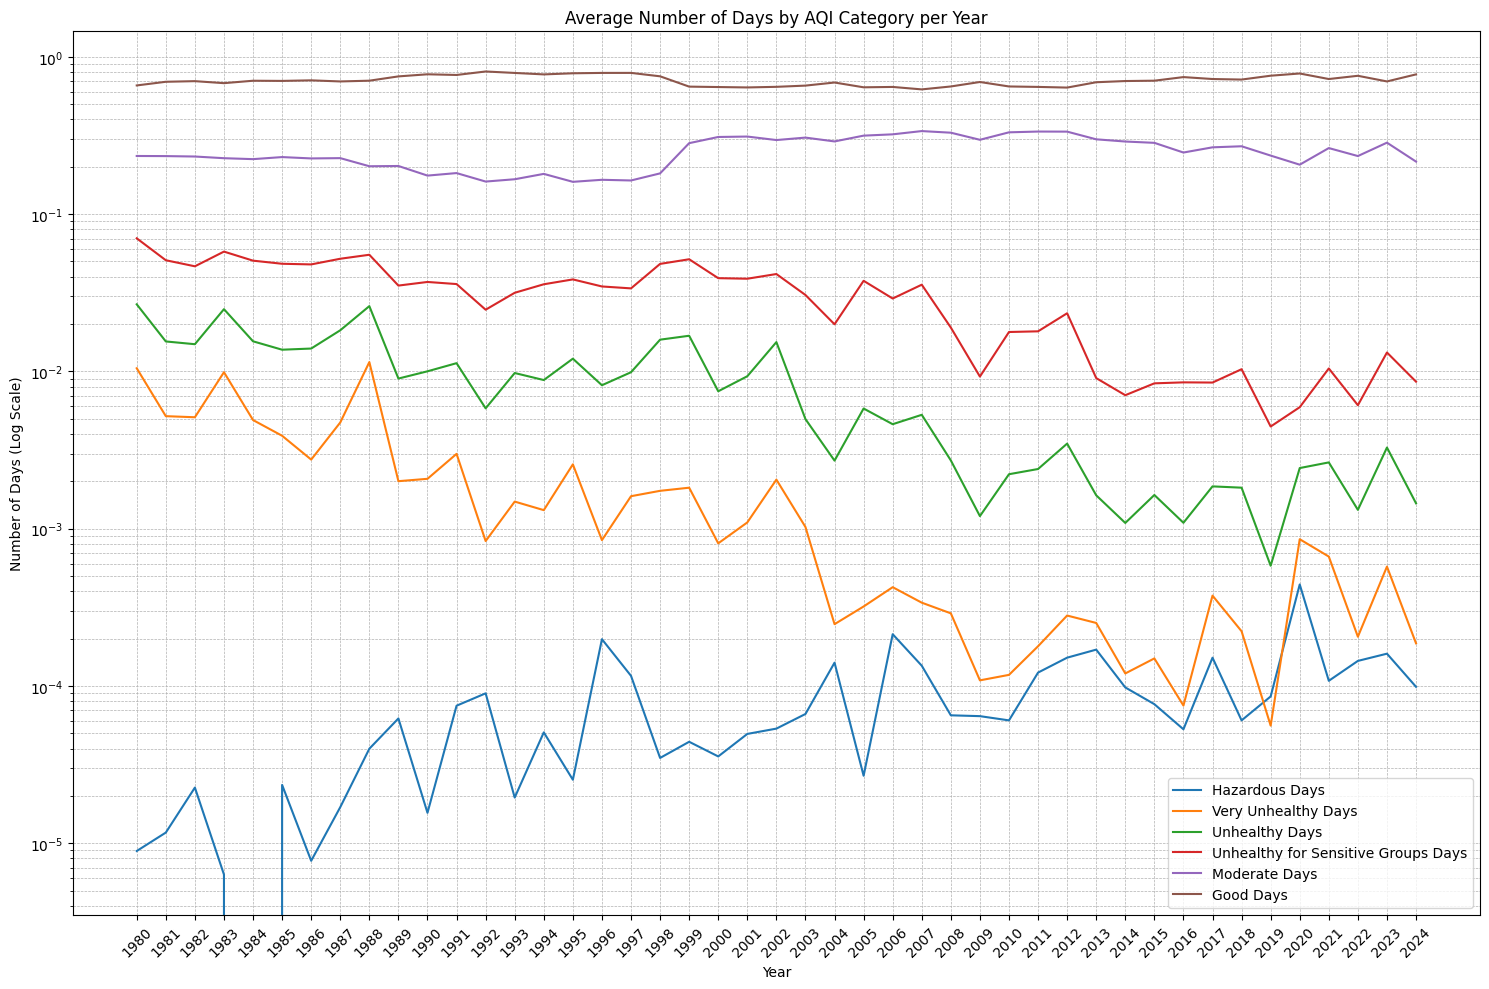

In [8]:
# Create the plot
plt.figure(figsize=(15, 10))

plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Hazardous Proportion'], label='Hazardous Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Very Unhealthy Proportion'], label='Very Unhealthy Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Unhealthy Proportion'], label='Unhealthy Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Unhealthy for Sensitive Groups Proportion'], label='Unhealthy for Sensitive Groups Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Moderate Proportion'], label='Moderate Days')
plt.plot(avg_byyear_bystate['Year'], avg_byyear_bystate['Yearly Good Proportion'], label='Good Days')

plt.yscale('log')  # for better visualization
plt.xlabel('Year')
plt.ylabel('Number of Days (Log Scale)')
plt.title('Average Number of Days by AQI Category per Year')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(avg_byyear_bystate['Year'], rotation=45)
plt.tight_layout()
plt.show()

In [9]:
aqi_df[aqi_df['Year'] == 1984].sort_values(by='Max AQI', ascending=False).head(5)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
30119,California,Los Angeles,1984,366,5,71,101,52,137,0,300,263,154,70,87,209,0,0
30127,California,Riverside,1984,366,52,116,40,52,106,0,300,243,110,29,105,232,0,0
30130,California,San Bernardino,1984,366,19,122,48,40,137,0,300,268,136,0,133,233,0,0
30449,Pennsylvania,Blair,1984,363,310,39,12,1,1,0,284,61,34,13,153,197,0,0
30471,Rhode Island,Kent,1984,300,198,51,24,15,12,0,281,143,42,0,0,300,0,0
